# Load Trained Model and Visualize Test Set Embeddings

- Loads a fine-tuned ResNet50 model from Google Drive
- Applies it to a labeled test dataset
- Extracts features and visualizes them using:
  - PCA + t-SNE
  - PCA + UMAP


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q "/content/drive/MyDrive/datasets.zip" -d "/content/datasets"

In [ ]:
import os
import shutil
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import umap.umap_ as umap
from tqdm import tqdm


In [ ]:
if os.path.exists('/content/datasets/separated_test_dataset/7'):
    os.makedirs('/content/data_excluded', exist_ok=True)
    shutil.move('/content/datasets/separated_test_dataset/7', '/content/data_excluded/7')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 7
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/resnet50_affectnet.pth', map_location=device))
model = model.to(device)
model.eval()
print("✅ Model loaded and ready.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model loaded and ready.


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder('/content/datasets/separated_test_dataset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
emotion_map = {0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger'}


In [ ]:
features, labels = [], []

with torch.no_grad():
    for images, lbls in tqdm(test_loader, desc="Extracting features"):
        images = images.to(device)
        x = model.conv1(images)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.avgpool(x)
        x = x.view(x.size(0), -1)
        features.append(x.cpu().numpy())
        labels.extend(lbls.cpu().numpy())

features = np.vstack(features)

Extracting features: 100%|██████████| 8872/8872 [56:41<00:00,  2.61it/s]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, verbose=True)
Wed May 14 15:31:24 2025 Construct fuzzy simplicial set
Wed May 14 15:31:24 2025 Finding Nearest Neighbors
Wed May 14 15:31:24 2025 Building RP forest with 32 trees
Wed May 14 15:31:35 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	Stopping threshold met -- exiting after 4 iterations
Wed May 14 15:32:02 2025 Finished Nearest Neighbor Search
Wed May 14 15:32:04 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed May 14 15:38:44 2025 Finished embedding


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


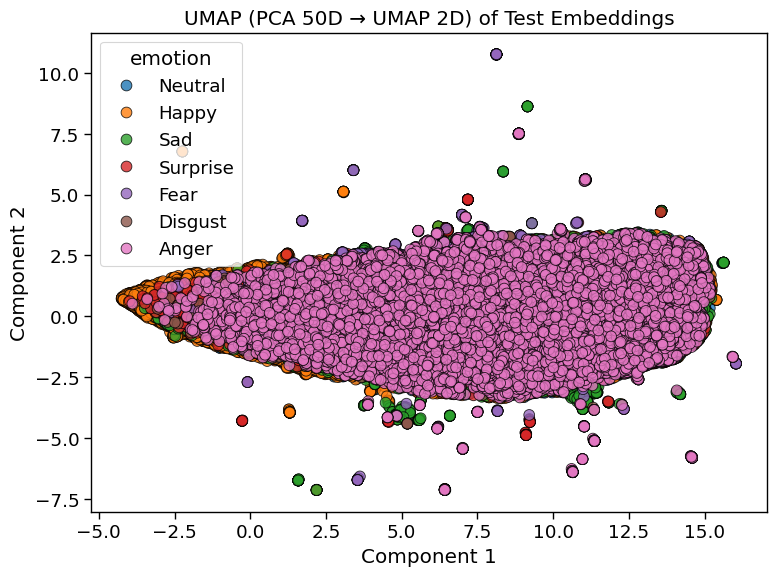

In [ ]:
pca_umap = PCA(n_components=50)
X_pca_umap = pca_umap.fit_transform(features)

umap_model = umap.UMAP(n_components=2, random_state=42, verbose=True)
X_umap = umap_model.fit_transform(X_pca_umap)

df_umap = pd.DataFrame({
    'x': X_umap[:, 0],
    'y': X_umap[:, 1],
    'emotion': [emotion_map[i] for i in labels]
})

plt.figure(figsize=(8, 6))
sns.set_context("paper", font_scale=1.5)
sns.scatterplot(data=df_umap, x='x', y='y', hue='emotion',
                palette='tab10', s=60, edgecolor='k', alpha=0.8)
plt.title("UMAP (PCA 50D → UMAP 2D) of Test Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/umap_plot_test.png", dpi=300)
plt.show()

In [ ]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"✅ Test Accuracy: {accuracy:.4f} ({correct}/{total})")

✅ Test Accuracy: 0.6111 (2139/3500)


In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=list(emotion_map.values())))

              precision    recall  f1-score   support

     Neutral       0.49      0.65      0.56       500
       Happy       0.75      0.87      0.81       500
         Sad       0.59      0.65      0.62       500
    Surprise       0.63      0.39      0.48       500
        Fear       0.56      0.73      0.64       500
     Disgust       0.73      0.43      0.54       500
       Anger       0.62      0.55      0.58       500

    accuracy                           0.61      3500
   macro avg       0.62      0.61      0.60      3500
weighted avg       0.62      0.61      0.60      3500



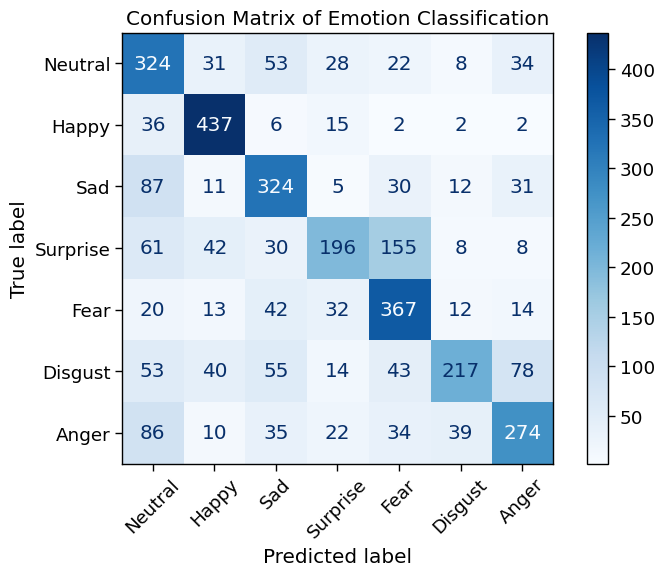

In [ ]:
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotion_map.values()))
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix of Emotion Classification")
plt.tight_layout()
plt.show()